# Base

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from   matplotlib import colors

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Helper Functions
Defining some helper functions to pad a given grid to 30x30, preprocess the images to one hot vectors and count the number of parameters in our model

In [3]:
def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def pad(grid, pad_value=10):
    h, w = len(grid), len(grid[0])
    output = torch.full((30, 30), pad_value, dtype=torch.int8)
    output[:h, :w] = torch.tensor(grid, dtype=torch.int8)
    return output

def preprocess(dataset):
        ret = F.one_hot(dataset, num_classes=11).permute(0, 3, 1, 2)
        return ret.float()

### Visualization
Simple function to visualize the grids for the ARC tasks

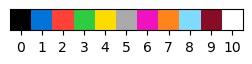

In [4]:
myColors = colors.ListedColormap(
    ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', "#FFFFFF"])
normalization = colors.Normalize(vmin=0, vmax=10)

def visualize(mat, ax, title=""):
    ax.imshow(mat, cmap=myColors, norm=normalization)
    ax.grid(True, which = 'both',color = 'lightgrey', linewidth = 0.5)
    ax.set_yticks([x-0.5 for x in range(1 + len(mat))])
    ax.set_xticks([x-0.5 for x in range(1 + len(mat[0]))]) 
    if len(title) > 0: ax.set_title(title)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.figure(figsize=(3, 1), dpi=100)
plt.imshow([list(range(10+1))], cmap=myColors, norm=normalization)
plt.xticks(list(range(10+1)))
plt.yticks([])
plt.show()

### Load Data 

In [5]:
with open("../input/arc-prize-2024/arc-agi_training_challenges.json", 'r') as f:
    train_challenges = json.load(f)
with open('../input/arc-prize-2024/arc-agi_training_solutions.json', 'r') as f:
    train_solutions = json.load(f)
with open("../input/arc-prize-2024/arc-agi_test_challenges.json", 'r') as f:
    test_challenges = json.load(f)
test_ids = list(test_challenges.keys())
train_ids = list(train_challenges.keys())

### Model Setup
Define Residual, Convolutional, Encoder, Decoder as well as Multi Layer Perceptron layers to be used by our ARCSolver CNN model. 

In [6]:
class ResBlock(nn.Module):
    def __init__(self, C: int, dropout: float):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.bnorm1 = nn.BatchNorm2d(C)
        self.bnorm2 = nn.BatchNorm2d(C)
        self.conv1 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = x
        r = self.conv1(self.relu(self.bnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.bnorm2(r)))
        return r + x

class ConvBlock(nn.Module):
    def __init__(self, mode: str, conv_in: int, conv_out: int, dropout: float):
        super().__init__()
        self.relu = nn.ReLU()
        self.bnorm = nn.BatchNorm2d(conv_out)
        if mode=="down":
            self.conv = nn.Conv2d(conv_in, conv_out, kernel_size=4, stride=2, padding=0)
        elif mode=="up":
            self.conv = nn.ConvTranspose2d(conv_in, conv_out, kernel_size=4, stride=2, padding=0)
        elif mode=="same":
            self.conv = nn.Conv2d(conv_in, conv_out, kernel_size=3, padding=1)
        else:
            raise ValueError("Invalid mode passed in to ConvBlock.")
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, z):
        x = self.conv(z)
        x = self.bnorm(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x


In [7]:
class Encoder(nn.Module):
    def __init__(self, channels=[256, 512, 512], latent_dim=512, dropout=0.1):
        super(Encoder, self).__init__()
        self.conv1 = ConvBlock("down", 11,  channels[0], dropout)
        self.res12 = ResBlock(channels[0], dropout)
        self.conv2 = ConvBlock("down", channels[0], channels[1], dropout)
        self.res23 = ResBlock(channels[1], dropout)
        self.conv3 = ConvBlock("down", channels[1], channels[2], dropout)
        self.fc = nn.Linear(channels[2] * 2 * 2, latent_dim)

    def forward(self, z):
        residuals = [0] * 3
        x = preprocess(z)
        x = self.conv1(x)
        x = self.res12(x)
        residuals[0] = x
        x = self.conv2(x)
        x = self.res23(x)
        residuals[1] = x
        x = self.conv3(x)
        residuals[2] = x
        x = x.reshape(x.size(0), -1)
        encoded = self.fc(x)
        return encoded, residuals
    
class Decoder(nn.Module):
    def __init__(self, channels=[256, 512, 512], latent_dim=512, dropout=0.1):
        super(Decoder, self).__init__()
        self.channels = channels
        self.fc = nn.Linear(latent_dim, channels[-1] * 2 * 2)
        self.conv3 = ConvBlock("up", channels[-1]*2, channels[-2], dropout)
        self.res32 = ResBlock(channels[-2], dropout)
        self.conv2 = ConvBlock("up", channels[-2]*2, channels[-3], dropout)
        self.res21 = ResBlock(channels[-3], dropout)
        self.conv1 = ConvBlock("up", channels[-3]*2, channels[-3], dropout)
        self.conv0 = nn.Conv2d(channels[-3], 11, kernel_size=3, padding=1)

    def forward(self, z, residuals):
        x = self.fc(z)
        x = x.reshape(x.size(0), self.channels[-1], 2, 2)
        x = torch.cat((x, residuals[2]), dim=1)
        x = self.conv3(x)
        x = self.res32(x)
        x = torch.cat((x, residuals[1]), dim=1)
        x = self.conv2(x)
        x = self.res21(x)
        x = torch.cat((x, residuals[0]), dim=1)
        x = self.conv1(x)
        x = self.conv0(x)
        return x
    
   
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.1):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1  = nn.Linear(input_size, hidden_size)
        self.bn1  = nn.BatchNorm1d(hidden_size)
        self.fc2  = nn.Linear(hidden_size, hidden_size)
        self.bn2  = nn.BatchNorm1d(hidden_size)
        self.fc3  = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.hidden_size = hidden_size
        self.output_size = output_size

    def forward(self, z):
        x = self.relu(self.bn1(self.fc1(z)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        output = self.fc3(x)
        return output

In [8]:
class ARCSolver(nn.Module):
    def __init__(self, channels, latent_dim, hidden_size, dropout=0.1):
        super(ARCSolver, self).__init__()
        self.encoder = Encoder(channels, latent_dim, dropout)
        self.decoder = Decoder(channels, latent_dim, dropout)
        self.mlp_key = MultiLayerPerceptron(latent_dim * 6, hidden_size, latent_dim)
        self.mlp_map = MultiLayerPerceptron(latent_dim * 2, hidden_size, latent_dim)
        self.channels    = channels
        self.latent_dim  = latent_dim
        self.hidden_size = hidden_size

    def forward(self, input, examples):
        # calculate key
        examples_encoded    = examples.flatten(end_dim=-3)
        examples_encoded, _ = self.encoder(examples_encoded)
        examples_encoded    = examples_encoded.reshape(2, -1, 3, self.latent_dim).permute(1, 0, 2, 3).flatten(start_dim=1)
        key = self.mlp_key(examples_encoded)
        # encode input
        input_encoded, residuals = self.encoder(input)
        # calculate encoded_output
        output_encoded = self.mlp_map(torch.concat((input_encoded, key), dim=1))
        # decode output
        output_decoded = self.decoder(output_encoded, residuals)
        return output_decoded

In [9]:
channels    = [256, 512, 512]
latent_dim  = 512
hidden_size = 512

model = ARCSolver(channels, latent_dim, hidden_size)
model_size = num_params(model)
print(f"model {int(model_size/1e6)}M")
print("encoder size:", num_params(model.encoder))
print("decoder size:", num_params(model.decoder))
print("mlp_key size:", num_params(model.mlp_key))
print("mlp_map size:", num_params(model.mlp_map))

model 38M
encoder size: 13292288
decoder size: 21661963
mlp_key size: 2100736
mlp_map size: 1052160


In [10]:
def model_pred(id_val):
    training_data = train_challenges[id_val]["train"]
    training_data = training_data[:3]
    while len(training_data) < 3:
        training_data += [training_data[-1]]

    input = pad(train_challenges[id_val]["test"][0]["input"]).unsqueeze(0)
    examples = torch.zeros((2, 1, 3, 30, 30), dtype=torch.int64)
    for j in range(3):
        examples[0, 0, j] = pad(training_data[j]["input"])
        examples[1, 0, j] = pad(training_data[j]["output"])
    input = input.long()
    examples = examples.long()

    output_pred_padded = torch.argmax(model(input, examples)[0], dim=0)
    lim_hor = (output_pred_padded[0] < 10).sum()
    lim_ver = (output_pred_padded[:, 0] < 10).sum()
    output_pred = output_pred_padded[:lim_ver, :lim_hor]
    return output_pred

def model_pred_final(id_val):
    training_data = test_challenges[id_val]["train"]
    training_data = training_data[:3]
    while len(training_data) < 3:
        training_data += [training_data[-1]]

    input = pad(test_challenges[id_val]["test"][0]["input"]).unsqueeze(0)
    examples = torch.zeros((2, 1, 3, 30, 30), dtype=torch.int64)
    for j in range(3):
        examples[0, 0, j] = pad(training_data[j]["input"])
        examples[1, 0, j] = pad(training_data[j]["output"])
    input = input.long()
    examples = examples.long()

    output_pred_padded = torch.argmax(model(input, examples)[0], dim=0)
    lim_hor = (output_pred_padded[0] < 10).sum()
    lim_ver = (output_pred_padded[:, 0] < 10).sum()
    output_pred = output_pred_padded[:lim_ver, :lim_hor]
    return output_pred

In [14]:
print(model.load_state_dict(torch.load("../input/arc-prize-2024/model_params.pth", map_location=device, weights_only=False)))
model.eval()
model.to(device);

<All keys matched successfully>


### Creating our Submission

In [36]:
submission = {}
for key, task in test_challenges.items():
    output_pred = model_pred_final(key).cpu().numpy()
    submission[key] = [{'attempt_1': output_pred.tolist(), 'attempt_2': output_pred.tolist()}]

with open('submission.json', 'w') as fp:
    json.dump(submission, fp)

print("Submission created successfully!")

Submission created successfully!


In [32]:
def score_submission():
    with open('../input/arc-prize-2024/arc-agi_evaluation_solutions.json', 'r') as sol_file:
        solutions = json.load(sol_file)
    
    with open('submission.json', 'r') as sub_file:
        submission = json.load(sub_file)
    
    overall_score = 0

    for task in solutions:
        score = 0
        for i, answer in enumerate(solutions[task]):
            attempt1_correct = submission[task][i]['attempt_1'] == answer
            attempt2_correct = submission[task][i]['attempt_2'] == answer
            score += int(attempt1_correct or attempt2_correct)

        score /= len(solutions[task])

        overall_score += score
    

    print(overall_score)

In [34]:
score_submission()

'''
my ans
"00576224": 
[{"attempt_1": [[3, 2, 8, 3], [7, 8, 8, 7], [7, 8, 8, 8], [3, 2, 7, 8]], "attempt_2": [[3, 2, 8, 3], [7, 8, 8, 7], [7, 8, 8, 8], [3, 2, 7, 8]]}]

expected ans
{"00576224": [[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]],
'''


0.0


'\nmy ans\n"00576224": \n[{"attempt_1": [[3, 2, 8, 3], [7, 8, 8, 7], [7, 8, 8, 8], [3, 2, 7, 8]], "attempt_2": [[3, 2, 8, 3], [7, 8, 8, 7], [7, 8, 8, 8], [3, 2, 7, 8]]}]\n\nexpected ans\n{"00576224": [[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]],\n'